# CoC Data Summarization
The number of people experiencing homelessness (PEP) is estimated every year during a point in time (PIT) count conducted in each continuum of care (CoC). The US Census Bureau conducts various surveys, including the 5-year American Community Survey, which collects critical data such as education, income, demographics, cost of living, fractions of the population receving assistance from government programs, and many others. 

The ACS5 survey provides high quality data at the census tract level. To associate the census features with CoCs, we represent a CoC as a combination of its constituent census tracts to create a data set consisting of PIT data and aggregated tract-level features.

In [2]:
import pandas as pd
from utils import *
from parameters import *
import openpyxl
from concurrent.futures import ThreadPoolExecutor
import geopandas as gpd
import matplotlib.pyplot as plt

## Methods
CoCs can contain many US Census Bureau tracts. For each tract constituting a CoC, we note the fraction of the total tract encompassed in the CoC. Tracts of which less than 1% of the total tract area is within the CoC are omitted.

Algorithmically, this is done by performing intersections between shape files and then calculating the total area of overlap after converting to an area-preserving coordinate reference system. Note that tracts may change on an annual basis; therefore, these data must be generated for each year. 

This formulation can be expressed succinctly as:

$$
x_i = \sum_{t \in \mathcal{T}} \alpha_t x_{it}
$$

where $x_i$ is value of feature $i$ for the CoC in question, $x_{it}$ is the value of feature $i$ for a census tract $t$, $\mathcal{T}$ is the set of census tracts that intersect the CoC, and $\alpha_t \in [0.01, 1]$ is the geographic weighting of census tract $t$, i.e., how much of tract $t$ is in the CoC.

For median, per capita, or other averaged features, such as household income or property value, we perform a population-weighted linear combination of the census tracts:

$$
\bar{x}_i = \sum_{t \in \mathcal{T}} \beta_t \bar{x}_{it}
$$

where 

$$
\beta_{t} = \frac{\alpha_t\mathrm{population}_t}{\sum_{t\in\mathcal{T}} \alpha_t \mathrm{population}_t}.
$$

In all modeling, we assume a uniform distribution of the population within a census tract. The set of features selected for this analysis are defined in ```census_features``` in ```parameters.py```. The functions to execute the algorithm described herein are defined in ```utils.py```.

In [3]:
census_api_key = "85e4d04ebdc75be192b6cd5444f6dc9970a95666"

# Test single year
summary_2023 = create_coc_summary(2023, census_api_key)
coc_gpd = create_cocs_graphs(2023, states)

Processing 2023


In [23]:
summary_2023_cocnum = summary_2023
summary_2023_cocnum['COCNUM'] = summary_2023.index.str.replace('_', '-')
coc_gpd_joined = coc_gpd.merge(
    summary_2023_cocnum,
    left_on="COCNUM",
    right_on="COCNUM",
    how = "left"
)
# coc_gpd.join

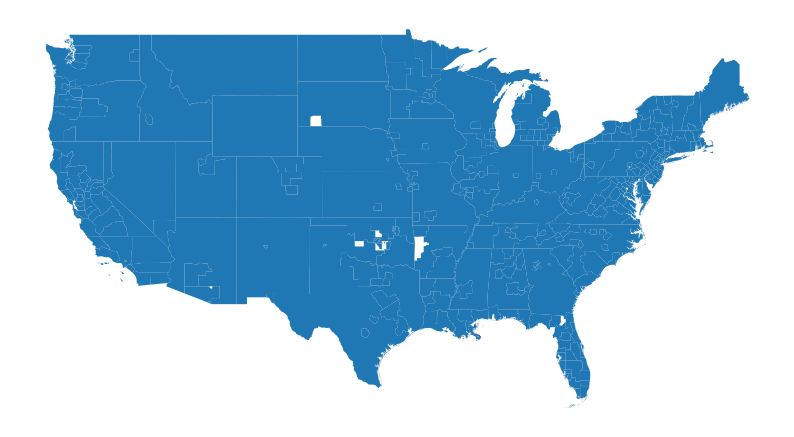

In [24]:
fig, ax = plt.subplots(
    figsize=(10,6)
)
coc_gpd.plot(
    ax = ax
)
ax.set_axis_off()

In [25]:
print(set(coc_gpd_joined['COCNUM']) - set(summary_2023_cocnum['COCNUM']))

set()


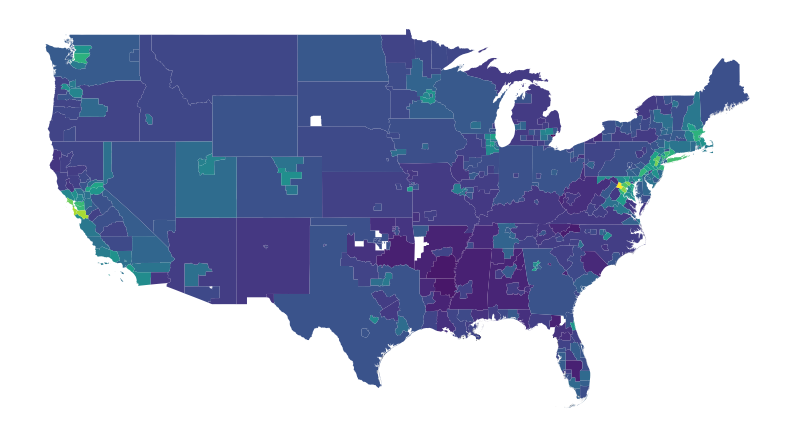

In [27]:
fig, ax = plt.subplots(
    figsize=(10,6)
)
coc_gpd_joined.plot(
    column = "median_household_income",
    ax = ax
)
ax.set_axis_off()

In [ ]:
# Aggregate data over all years from 2011 through 2023; at the time of this work, data ACS5 for 2024 was not yet available.
years = range(2011, 2024)

# Execute queries in parallel
with ThreadPoolExecutor(max_workers=10) as parallel_executor:
    futures = []
    for year in years:
        futures.append(parallel_executor.submit(create_coc_summary, year, census_api_key))

with pd.ExcelWriter('coc_summary_5.xlsx') as writer:
    for yr, fut in zip(years, futures):
        try:
            df = fut.result()
            df.to_excel(writer, sheet_name=str(yr), index=True)
        except Exception as e:
            print(f"Year {yr}: {e}")